### This workbook is about building a predictive model for churn analysis

The structure of this workbook:

1. Obtain the data

2. Analysis
    * (1) overview of all features
    * (2) Analyze numerical variables
    * (3) Analyze categorical variables
    * (4) Analyze correlation between features
    * (5) Assumptions based on the analysis

3. Wrangle the data
	* (1) Drop some columns and remove some categories
	* (2) Deal with missing values
	* (3) Create engineering features
	* (4) Converting categorical features 
	* (5) Remove highly correlated features

4. Model Training
	* (1) Logistic regression (train and evaluate)
	* (2) Random forest (train and evaluate)

5. Plot survival curve and analyze it



In [623]:
from datetime import datetime
from typing import List, Dict
import re
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mglearn
from lifelines import KaplanMeierFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
#from sklearn.utils.fixes import signature
from inspect import signature
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_recall_curve, \
roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, precision_score, make_scorer, f1_score,\
roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectPercentile

# 1. Get the data

In [624]:
DIR = r"D:\OneDrive - insidemedia.net\project\data-science-project\classification\telco-customer-churn"
df = pd.read_csv(DIR + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_o = df.copy()

# 2. Analysis

### (1) Overview of all features

In [625]:
df_o.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [626]:
# identify different data type of the variables. check numerical variable and categorical variables

print(df.info(), '\n')
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Columns
customerID: Customer ID
gender: Whether the customer is a male or a female
SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
Partner: Whether the customer has a partner or not (Yes, No)
Dependents: Whether the customer has dependents or not (Yes, No)
tenure: Number of months the customer has stayed with the company
PhoneService: Whether the customer has a phone service or not (Yes, No)
MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)
DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)
Contract: The contract term of the customer (Month-to-month, One year, Two year)
PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
MonthlyCharges: The amount charged to the customer monthly
TotalCharges: The total amount charged to the customer
Churn: Whether the customer churned or not (Yes or No)

In [627]:
# look at the values in all variables. we can potentially know some values in the categorical variable might need to be adjusted.

for j in range(df.shape[1]):
    print(df.columns[j])
    print(df.iloc[:, j].value_counts())
    print('\n')

customerID
8824-RWFXJ    1
0314-TKOSI    1
6840-RESVB    1
0730-BGQGF    1
3528-HFRIQ    1
6425-JWTDV    1
2465-BLLEU    1
5961-VUSRV    1
8165-ZJRNM    1
3148-BLQJT    1
7610-TVOPG    1
9239-GZHZE    1
9720-JJJOR    1
7929-SKFGK    1
9629-NHXFW    1
7643-RCHXS    1
6169-PPETC    1
0931-MHTEM    1
8631-WUXGY    1
9040-KZVWO    1
0929-PECLO    1
8467-WYNSR    1
8495-LJDFO    1
9068-FHQHD    1
2688-BHGOG    1
8277-RVRSV    1
9774-NRNAU    1
5180-UCIIQ    1
8718-PTMEZ    1
7603-USHJS    1
             ..
4973-MGTON    1
5566-SOEZD    1
7968-QUXNS    1
0657-DOGUM    1
5906-BFOZT    1
9142-XMYJH    1
2604-XVDAM    1
1236-WFCDV    1
0869-PAPRP    1
7739-LAXOG    1
7089-RKVSZ    1
9961-JBNMK    1
6439-LAJXL    1
4468-KAZHE    1
4430-YHXGG    1
8775-LHDJH    1
2661-GKBTK    1
5222-JCXZT    1
6352-TWCAU    1
0096-BXERS    1
9283-LZQOH    1
2146-EGVDT    1
5016-LIPDW    1
2058-DCJBE    1
7000-WCEVQ    1
5146-YYFRZ    1
4332-MUOEZ    1
2632-IVXVF    1
8992-JQYUN    1
7746-QYVCO    1
Name: custome

In [628]:
# missing values

def missing_percent(df: pd.DataFrame) -> Dict:
    """Calculate the percentage of the missing data in each columns"""
    percent = {}
    for column_name in list(df.columns):
        percent[column_name] = sum(df[column_name].isnull()) / len(df[column_name])
    return percent

percent = missing_percent(df)
percent 


{'customerID': 0.0,
 'gender': 0.0,
 'SeniorCitizen': 0.0,
 'Partner': 0.0,
 'Dependents': 0.0,
 'tenure': 0.0,
 'PhoneService': 0.0,
 'MultipleLines': 0.0,
 'InternetService': 0.0,
 'OnlineSecurity': 0.0,
 'OnlineBackup': 0.0,
 'DeviceProtection': 0.0,
 'TechSupport': 0.0,
 'StreamingTV': 0.0,
 'StreamingMovies': 0.0,
 'Contract': 0.0,
 'PaperlessBilling': 0.0,
 'PaymentMethod': 0.0,
 'MonthlyCharges': 0.0,
 'TotalCharges': 0.0,
 'Churn': 0.0}

### (2) Analyze numerical variables 

In [629]:
# descriptive analysis of the numerical variables

df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [630]:
# plot the distribution

def plot_numeric(df, feature_list):
    fig, axis = plt.subplots(1, len(feature_list), figsize=(16, 4))
    for i in range(len(feature_list)):
        df[feature_list[i]].plot.hist(ax=axis[i])
        axis[i].set_title(feature_list[i])

TotalCharges is actually float, but because it contains a invalid str, we need to remove those entries

In [631]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df.shape)
df.dropna(subset=['TotalCharges']).shape

(7043, 21)


(7032, 21)

Only 11 rows, not bad, just drop them

In [632]:
df.dropna(subset=['TotalCharges'], inplace=True)
df.shape

(7032, 21)

Convert Churn yes/no to 1/0 for better analysis and prediction

In [633]:
df['Churn'] = df.Churn.map({'No': 0, 'Yes': 1})

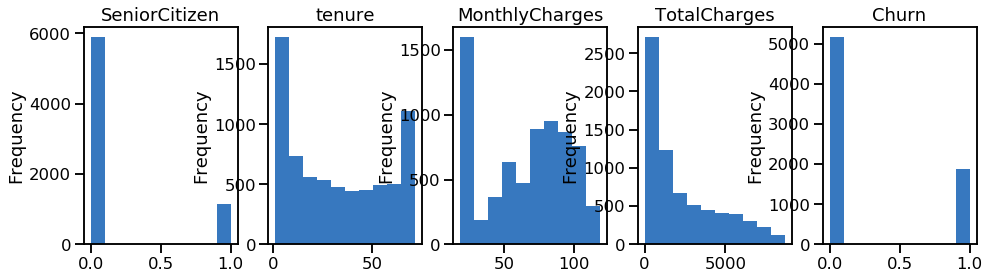

In [634]:
feature_list = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
plot_numeric(df, feature_list)

### (3) Analyze categorical variables

In [635]:
df.describe(include=[np.object])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,7032,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,8824-RWFXJ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,1,3549,3639,4933,6352,3385,3096,3497,3087,3094,3472,2809,2781,3875,4168,2365


In [636]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [637]:
# plot the unique counts for the categorical variables

def plot_categorical(df, categorical_variables_list: List):
    nrows = 1
    ncols = int(np.ceil(len(categorical_variables_list) / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4))

    for i in range(len(categorical_variables_list)):
        df.loc[:, categorical_variables_list[i]].value_counts().plot.barh(ax=axes[i])
        axes[i].set_title(categorical_variables_list[i])




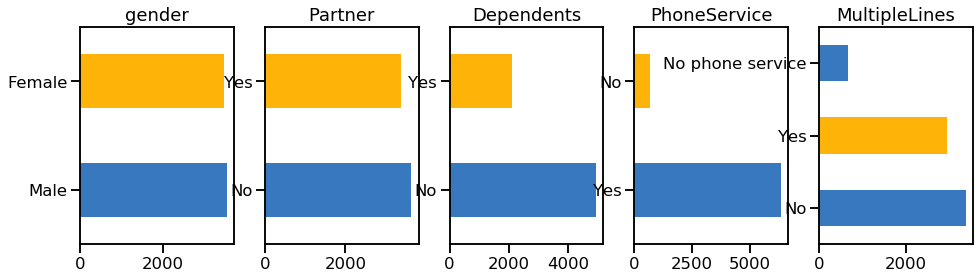

In [638]:
plot_categorical(df, ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines'
       ])

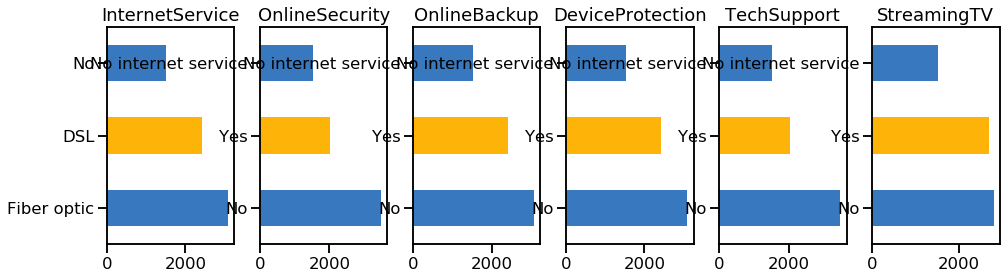

In [639]:
plot_categorical(df, ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV'  ])

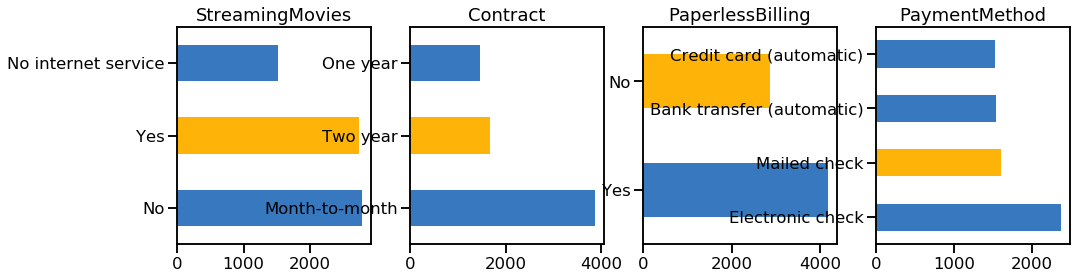

In [640]:
plot_categorical(df, [ 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'])

### (4) Summary



 **Which features are available in the dataset?**

 * https://www.kaggle.com/blastchar/telco-customer-churn


 **Which features have missing values?**
 * none
 

 **What are the numeric variables and categorical variables?**

 * Numerical variables: (1) continuous: 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges'; (2) discrete: 'tenure' .
 * Categorial variables: Others 


 **What is the distribution of numerical feature values across the samples?**



 **What is the distribution of categorical features?**


**Which features are mixed data types?**
  Numerical, alphanumeric data within same feature. These are candidates for correcting goal.
 * CustomID: a mix of numeric and alphanumeric data types. 



**Which features may contain errors or typos?**


**which feature I should select? preliminary inspection**

 * only drop CustomID



### (5) Analyze correlation between features and target



#### (a) Numerical variable vs. target variable

#### descriptive

In [642]:
df.groupby('Churn').mean()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
Churn,,,,
0,0.128995,37.650010,61.307408,2555.344141
1,0.254682,17.979133,74.441332,1531.796094


#### visulization

mean

C:\Users\music\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


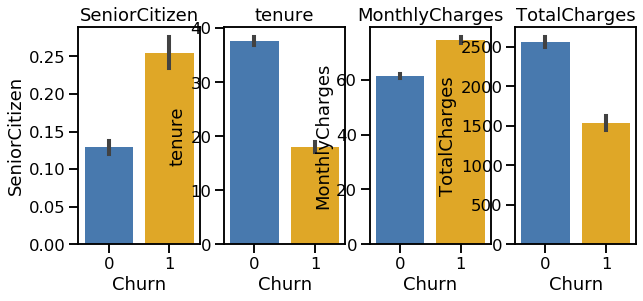

In [643]:
def plot_numerical_target(df, feature_list, target):
    fig, axis = plt.subplots(1, len(feature_list), figsize=(10, 4))
    for i in range(len(feature_list)):
        sns.catplot(ax=axis[i], data=df, x=target, y=feature_list[i], kind='bar')
        axis[i].set_title(feature_list[i])
    
plot_numerical_target(df, ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], 'Churn')
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)


distribution 

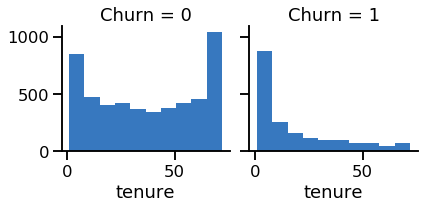

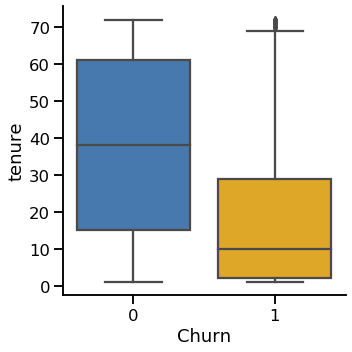

In [644]:
g = sns.FacetGrid(data=df, col='Churn')
g.map(plt.hist, 'tenure')

sns.catplot(data=df, x='Churn', y='tenure', kind='box')


two features

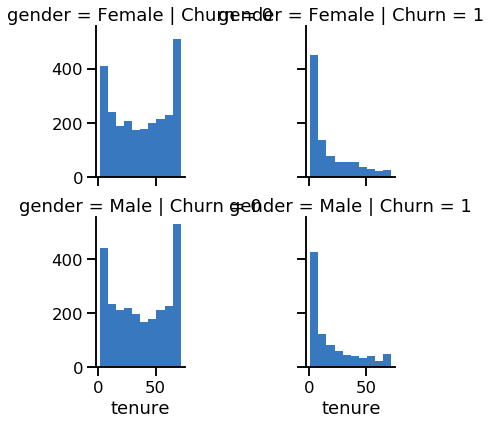

In [645]:
# We can combine multiple features for identifying correlations using a single plot. 
# This can be done with numerical and categorical features which have numeric values.

g = sns.FacetGrid(data=df, row='gender', col='Churn')
g.map(plt.hist, 'tenure')


c:\program files\python37\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


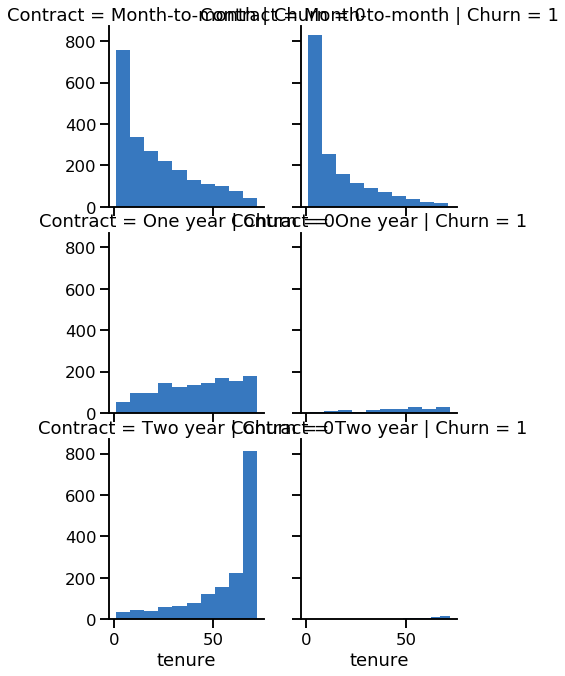

In [646]:
g = sns.FacetGrid(data=df, row='Contract', col='Churn')
g.map(plt.hist, 'tenure')

MonthlyCharges

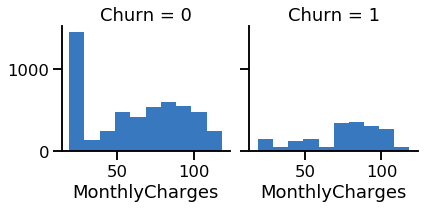

In [647]:
g = sns.FacetGrid(data=df, col='Churn')
g.map(plt.hist, 'MonthlyCharges')

TotalCharges

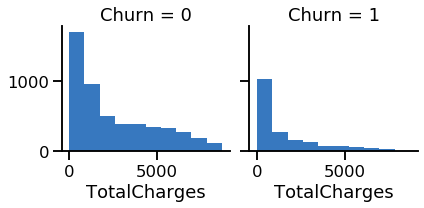

In [648]:
g = sns.FacetGrid(data=df, col='Churn')
g.map(plt.hist, 'TotalCharges')

**Summary**


####  (c) Categorical variable vs. target variable

##### descriptive

In [649]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [650]:
def cat_target(df, feature, target):
    for i in range(len(feature)):
        print(df.groupby(by=feature[i]).mean().sort_values(by=target, ascending=False), '\n')  

In [651]:
cat_target(df, [ 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'], 'Churn')

        SeniorCitizen     tenure  MonthlyCharges  TotalCharges     Churn
gender                                                                  
Female       0.163078  32.290841       65.216652   2283.190985  0.269595
Male         0.161736  32.550296       64.387546   2283.407861  0.262046 

                  tenure  MonthlyCharges  TotalCharges     Churn
SeniorCitizen                                                   
1              33.295972       79.820359   2810.465193  0.416813
0              32.252292       61.885594   2181.089550  0.236503 

         SeniorCitizen     tenure  MonthlyCharges  TotalCharges     Churn
Partner                                                                  
No            0.156362  23.370706       61.956472   1584.960429  0.329761
Yes           0.168877  42.129089       67.845977   3032.271648  0.197171 

            SeniorCitizen     tenure  MonthlyCharges  TotalCharges     Churn
Dependents                                                           

**Summary**



##### visulization

In [652]:
df_churn = df[df['Churn'] == 1]
df_notchurn = df[df['Churn'] == 0]

not Churn

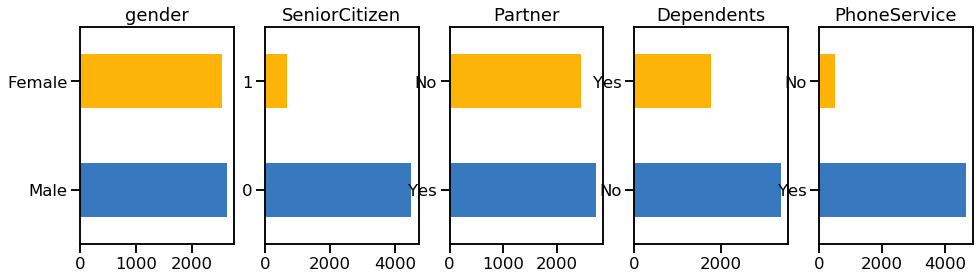

In [653]:
plot_categorical(df_notchurn, ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService'])

 churn

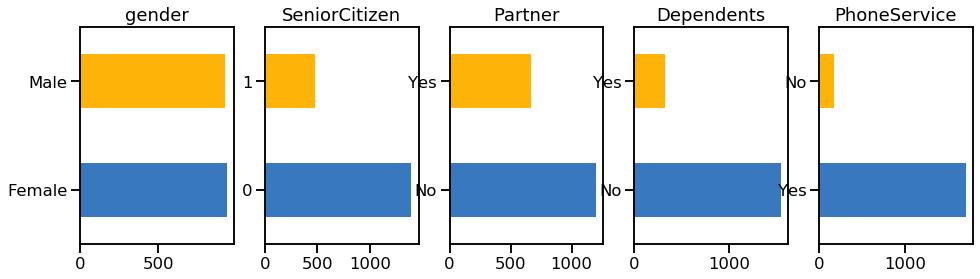

In [654]:
plot_categorical(df_churn, ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService'])

not Churn

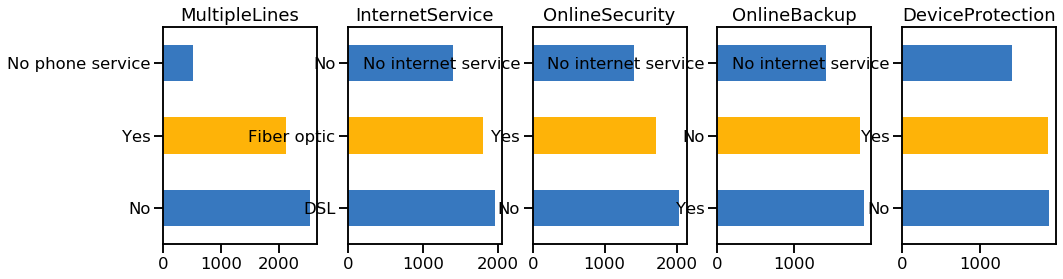

In [655]:
plot_categorical(df_notchurn, [ 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'])


churn

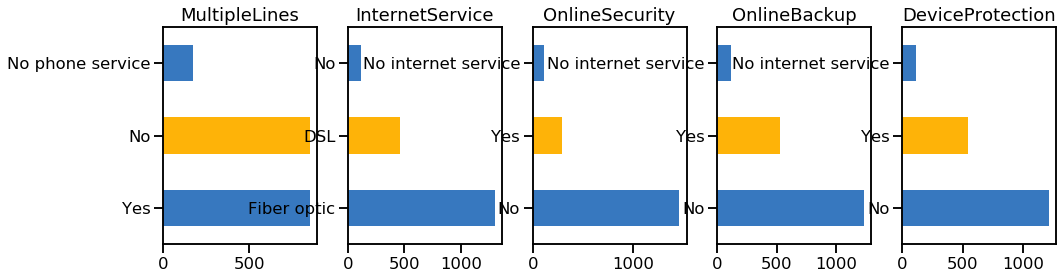

In [656]:
plot_categorical(df_churn, [ 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'])


not churn

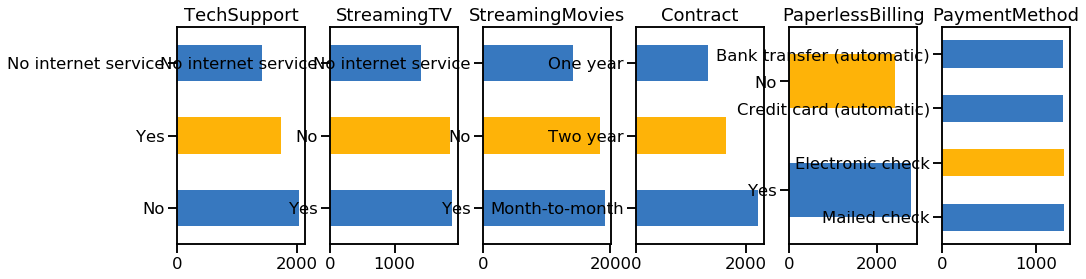

In [657]:
plot_categorical(df_notchurn, ['TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'])

Churn

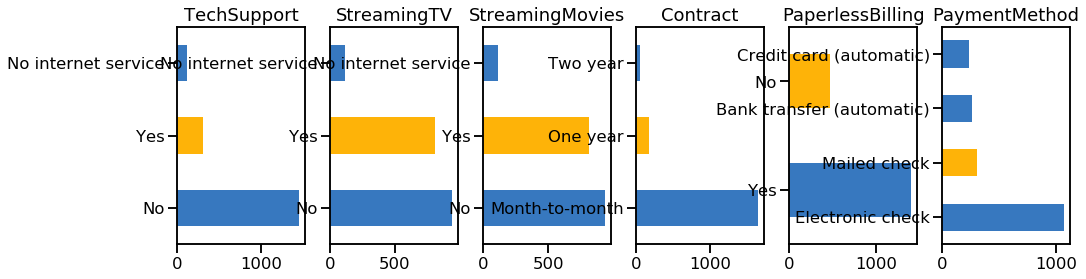

In [658]:
plot_categorical(df_churn, ['TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod'])

c:\program files\python37\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\program files\python37\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\program files\python37\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\music\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] 

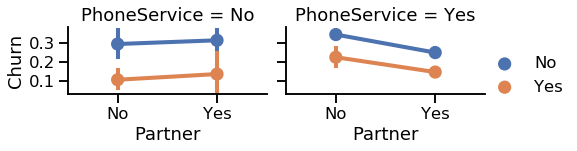

In [659]:
grid = sns.FacetGrid(df, col='PhoneService', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Partner', 'Churn', 'Dependents', palette='deep')
grid.add_legend()

**Summary**
* some facotors are favorable to churn

### (6) Assumtions based on data analysis



We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with Churn. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

**Correcting.**

**Creating.**


**Classifying.**



# 3.  Wrangle data

We have already processed the data a little bit:
    (1) drop the invalid row in TotalCharges column
    (2) convert Churn label Yes/No to 1/0
now we continue to wrangle the data further 

###  (1) Drop some columns or remove some categories

In [661]:
print('before', df.shape)

df.drop(columns=['customerID'], inplace=True)

print('after', df.shape)

before (7032, 21)
after (7032, 20)


### (2) missing values
no missing vluaes

### (3)  Create engineering features

### (4) Converting a categorical feature

In [662]:
df = pd.get_dummies(df)


In [663]:
# save the df for future analysis
df_copy = df.copy()  # for plotting later

### (5) remove correlated features
After have done the test, removing correlated features didn't improve the model performance. But it may be good for the interpretation of the linear model

In [664]:
### Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = df.corr().abs()
print('corr_matrix', corr_matrix.head())

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
print('upper', upper.head())

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)
print('There are %d columns to remove :' % (len(to_drop)))


corr_matrix                 SeniorCitizen    tenure  MonthlyCharges  TotalCharges  \
SeniorCitizen        1.000000  0.015683        0.219874      0.102411   
tenure               0.015683  1.000000        0.246862      0.825880   
MonthlyCharges       0.219874  0.246862        1.000000      0.651065   
TotalCharges         0.102411  0.825880        0.651065      1.000000   
Churn                0.150541  0.354049        0.192858      0.199484   

                   Churn  gender_Female  gender_Male  Partner_No  Partner_Yes  \
SeniorCitizen   0.150541       0.001819     0.001819    0.016957     0.016957   
tenure          0.354049       0.005285     0.005285    0.381912     0.381912   
MonthlyCharges  0.192858       0.013779     0.013779    0.097825     0.097825   
TotalCharges    0.199484       0.000048     0.000048    0.319072     0.319072   
Churn           1.000000       0.008545     0.008545    0.149982     0.149982   

                Dependents_No             ...              \
S

In [665]:
df.drop(columns=to_drop, inplace=True)

In [666]:
df.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No',
       'MultipleLines_No', 'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

### (5) separate features and target

In [667]:
def split_to_features_labels(df: pd.DataFrame, feature_list: List, label_list: List) -> Tuple[pd.DataFrame, pd.Series]:
    """ Split the data into feature matrix and the labels vector"""
    df_features = df[feature_list]
    df_label = df[label_list]
    return df_features, df_label

In [668]:
feature_list = list(set(list(df.columns)) - set(['Churn']))

In [669]:
label_list = 'Churn'
df_features, df_label = split_to_features_labels(df, feature_list, label_list)

### (6) split into train set and test set


In [670]:
X_trainval, X_test, y_trainval, y_test = train_test_split( df_features, df_label, test_size=0.2, random_state=0)

### (7) feature selection
using univariate to drop some feature actually reduce the model performance. I don't use it. 

In [713]:
select = SelectPercentile(percentile=80)
select.fit(X_trainval, y_trainval)
X_trainval_selected = select.transform(X_trainval)
X_test_selected = select.transform(X_test)


In [714]:
mask = select.get_support()
temp = pd.DataFrame(index=X_trainval.columns, data=mask, columns=['boolen'])
print(temp.sort_values(by='boolen'))

                                         boolen
StreamingMovies_Yes                       False
gender_Female                             False
MultipleLines_Yes                         False
DeviceProtection_Yes                      False
StreamingTV_Yes                           False
MultipleLines_No                          False
PhoneService_No                           False
InternetService_No                         True
OnlineSecurity_No                          True
DeviceProtection_No                        True
OnlineBackup_No                            True
TechSupport_No                             True
MonthlyCharges                             True
Dependents_No                              True
PaymentMethod_Credit card (automatic)      True
OnlineBackup_Yes                           True
Partner_No                                 True
PaymentMethod_Bank transfer (automatic)    True
InternetService_DSL                        True
StreamingMovies_No                      

# 4. Model training

## Logistic regression 

In [673]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.1, 1, 10, 100, 1000],
             'solver': ['liblinear']}
scorer = make_scorer(f1_score)

model_lg = GridSearchCV(estimator=LogisticRegression(), 
                        scoring = scorer,
                        param_grid = param_grid,
                        cv=5)

model_lg.fit(X_trainval, y_trainval)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), verbose=0)

In [674]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.1, 1, 10, 100, 1000],
             'solver': ['liblinear']}
scorer = make_scorer(f1_score)

model_lg = GridSearchCV(estimator=LogisticRegression(), 
                        scoring = scorer,
                        param_grid = param_grid,
                        cv=5)

model_lg.fit(X_trainval, y_trainval)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(f1_score), verbose=0)

###  evaluate the parameters

In [675]:
mean_test_score = model_lg.cv_results_['mean_test_score']
print('mean_test_score for different paramters \n', mean_test_score)
print('best scores \n', model_lg.best_score_)    
print('best estimator \n', model_lg.best_estimator_)
print('best parameters \n', model_lg.best_params_)

mean_test_score for different paramters 
 [0.55246827 0.57402988 0.59598675 0.5951754  0.60167657 0.59573299
 0.60187119 0.5987657  0.60214561 0.59337206 0.60236305 0.59337206]
best scores 
 0.6023630482879432
best estimator 
 LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
best parameters 
 {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


In [676]:
results = pd.DataFrame(model_lg.cv_results_)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031000,0.003224,0.003000,5.840039e-07,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.579041,0.531915,0.572426,0.557377,0.521583,0.552468,0.022382,12
1,0.033800,0.008567,0.002599,7.981062e-04,0.001,l2,liblinear,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.585635,0.573557,0.592727,0.582857,0.535373,0.574030,0.020282,11
2,0.094797,0.015816,0.003001,1.096106e-03,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.609319,0.590826,0.596491,0.605263,0.578035,0.595987,0.011072,6
3,0.038199,0.002483,0.003199,4.003530e-04,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.608229,0.582418,0.595070,0.599251,0.590909,0.595175,0.008579,8
4,0.085197,0.036045,0.002800,4.000671e-04,1,l1,liblinear,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.608541,0.596364,0.598592,0.601113,0.603774,0.601677,0.004233,4


[[0.55246827 0.57402988 0.59598675 0.5951754  0.60167657 0.59573299]
 [0.60187119 0.5987657  0.60214561 0.59337206 0.60236305 0.59337206]]


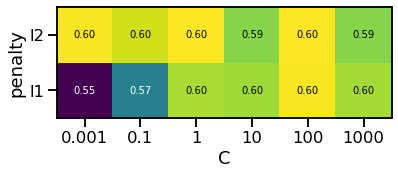

In [677]:
scores = np.array(results.mean_test_score).reshape(2, 6)
print(scores)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['C'],
                      ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. 
This can be done by calculating the coefficient of the features in the decision function. Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

In [678]:
coeff_df = pd.DataFrame(feature_list)
coeff_df.columns = ['Feature']
coeff_df["coefficient"] = pd.Series(model_lg.best_estimator_.coef_[0])
coeff_df.sort_values(by='coefficient', ascending=False)

,Feature,coefficient
1,InternetService_Fiber optic,0.515487
13,StreamingTV_Yes,0.368246
9,PhoneService_No,0.354405
31,Contract_Month-to-month,0.333067
7,SeniorCitizen,0.269395
20,OnlineSecurity_No,0.261765
6,StreamingTV_No,0.205793
26,Dependents_No,0.205543
27,DeviceProtection_Yes,0.189765
0,OnlineBackup_No,0.173539


In [679]:
model_lg.best_estimator_.intercept_

array([0.13246494])

**Summary**



### evaluate the performance in the test data set

In [680]:
probs = model_lg.predict_proba(X_test)
predicted = model_lg.predict(X_test)

#### (1) accuracy 

In [681]:
accuracy = accuracy_score(y_test, predicted)
print('accuracy for the test data is: ', accuracy)

accuracy for the test data is:  0.8052594171997157


#### (2) classification report

In [682]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1038
           1       0.65      0.54      0.59       369

    accuracy                           0.81      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407



**summary**
* F1 score for lable 1 is 0.6 in the training set, and 0.59 for the test set. The model generalize well. 

#### (3) precision_recall_curve

In [683]:
def plot_precision_recall_curve(y_test: pd.DataFrame, probability: pd.DataFrame, predicted: pd.DataFrame ):
    """Plot the recall precision tradeoff"""
   
    precision, recall, threshold = precision_recall_curve(y_test, probability)
    #print('precision is', precision)
    #print('recall is', recall)
    
    precision_ = precision_score(y_test, predicted)
    print('precision is ', precision_)
    recall_ = recall_score(y_test, predicted)
    print('recall is', recall_)
    f1 = f1_score(y_test, predicted)
    print('f1 score is', f1)
    
    average_precision = average_precision_score(y_test, probability)
    print('average precision is', average_precision)
    
    # calculate precision-recall AUC (area under the curve)
    auc_ = auc(recall, precision)
    print('precision-recall AUC is', auc_)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                    if 'step' in signature(plt.fill_between).parameters
                    else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))


precision is  0.6547231270358306
recall is 0.5447154471544715
f1 score is 0.5946745562130177
average precision is 0.6502134829228503
precision-recall AUC is 0.649477789160658


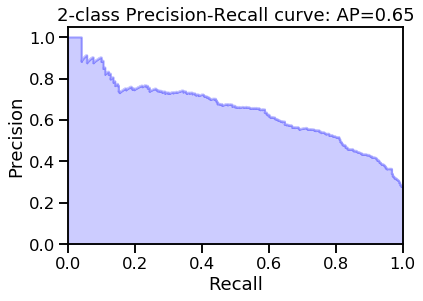

In [684]:
predicted = model_lg.predict(X_test)
plot_precision_recall_curve(y_test, probs[:,1], predicted)

#### (4) ROC curve


In [685]:
def plot_roc_curve(y_test: pd.DataFrame, probability: pd.DataFrame):
    plt.figure()
    fpr, tpr, threshold = roc_curve(y_test, probability)
    roc_auc = auc(tpr, fpr)    # Compute Area Under the Curve (AUC) using the trapezoidal rule
    
    # Plotting
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    print('ROC AUC(area under the curve) is', roc_auc_score(y_test, probability)) 
    print('threshold values :', threshold[0: 20])

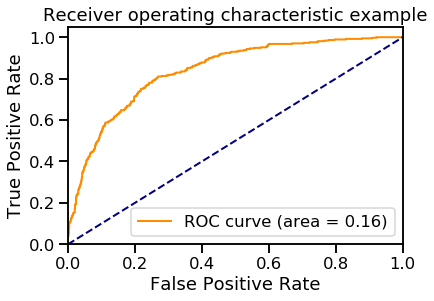

ROC AUC(area under the curve) is 0.8379714481152519
threshold values : [1.85999987 0.85999987 0.79210878 0.78802299 0.7796082  0.77768993
 0.77439532 0.77232077 0.75591265 0.75560692 0.75436371 0.75236075
 0.74702749 0.74631319 0.7424411  0.74216867 0.74007173 0.73861255
 0.73472849 0.73419906]


In [686]:
plot_roc_curve(y_test, np.ravel(probs[:,1]))

## Random Forest

In [687]:
#param_grid = {'n_estimators': [1, 30, 100], 'max_features': ['auto', 'log2'],  
#              'max_depth': [2, 4, 8, 16], 'criterion': ['gini', 'entropy']
#}

param_grid = {'n_estimators': [2000], 'max_features': ['log2', 'auto'],  
              'max_depth': [4, 8, 16], 'criterion': ['gini', 'entropy']
}

scorer = make_scorer(f1_score)

model_rf = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), 
                        scoring = scorer,
                        param_grid = param_grid,
                        cv=5)

model_rf.fit(X_trainval, y_trainval)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='

In [688]:
mean_test_score = model_rf.cv_results_['mean_test_score']
print('mean_test_score for different paramters \n', mean_test_score)
print('best scores \n', model_rf.best_score_)    
print('best estimator \n', model_rf.best_estimator_)
print('best parameters \n', model_rf.best_params_)

mean_test_score for different paramters 
 [0.50733345 0.50180333 0.58899139 0.58868008 0.55906332 0.55802484
 0.49767156 0.50085979 0.58901313 0.58746788 0.56157777 0.56086908]
best scores 
 0.58901312996699
best estimator 
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
best parameters 
 {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 2000}


In [689]:
coeff_df = pd.DataFrame(feature_list)
coeff_df.columns = ['Feature']
coeff_df["Coefficient"] = pd.Series(model_rf.best_estimator_.feature_importances_)
coeff_df.sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
10,tenure,0.137943
31,Contract_Month-to-month,0.131942
11,TotalCharges,0.111368
25,MonthlyCharges,0.085216
8,Contract_Two year,0.070191
20,OnlineSecurity_No,0.057675
1,InternetService_Fiber optic,0.052564
24,TechSupport_No,0.051080
32,PaymentMethod_Electronic check,0.044466
5,Contract_One year,0.022024


**Summary** 

### evaluate the performance in the test data set

In [690]:
probs = model_rf.predict_proba(X_test)
predicted = model_rf.predict(X_test)

#### (1) accuracy 

In [691]:
accuracy = accuracy_score(y_test, predicted)
print('accuracy for the test data is: ', accuracy)

accuracy for the test data is:  0.8038379530916845


In [692]:
accuracy_score(y_test, predicted)

0.8038379530916845

#### (2) classification report

In [693]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1038
           1       0.67      0.50      0.57       369

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



**summary**
* F1 score for lable 1 is  in the training set, and  for the test set. The model generalize well. 

#### (3) precision_recall_curve

precision is  0.6666666666666666
recall is 0.5040650406504065
f1 score is 0.574074074074074
average precision is 0.6657274144654767
precision-recall AUC is 0.6649308818675193


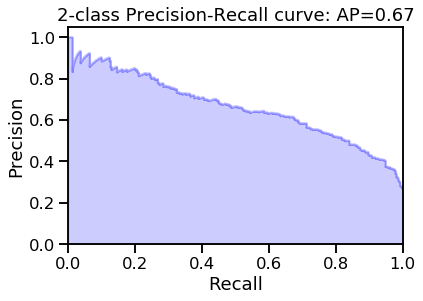

In [694]:
predicted = model_rf.predict(X_test)
plot_precision_recall_curve(y_test, probs[:,1], predicted)

#### (4) ROC curve


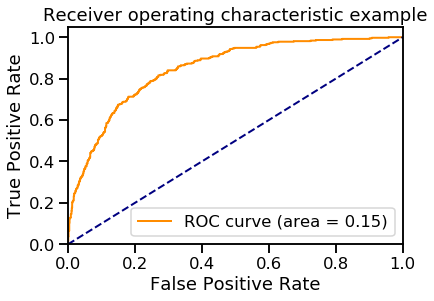

ROC AUC(area under the curve) is 0.8468508336335772
threshold values : [1.85885614 0.85885614 0.84052087 0.83922901 0.82179571 0.8217562
 0.80943825 0.79516419 0.74978571 0.74886342 0.73436196 0.73388459
 0.72996433 0.72780489 0.72626899 0.72365785 0.70875623 0.70539695
 0.69461162 0.69392245]


In [695]:
plot_roc_curve(y_test, np.ravel(probs[:,1]))

###  compare logistic regression with random forest

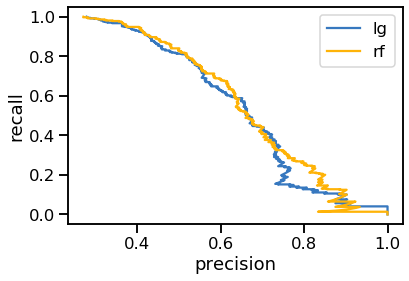

In [696]:
presicion_lg, recall_lg, thresholds_lg = precision_recall_curve(y_test, model_lg.predict_proba(X_test)[:, 1])
plt.plot(presicion_lg, recall_lg, label='lg')

presicion_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
plt.plot(presicion_rf, recall_rf, label='rf')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')

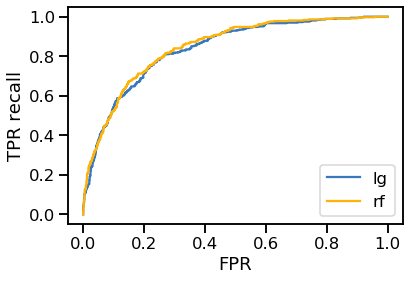

In [697]:
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, model_lg.predict_proba(X_test)[:, 1])
plt.plot(fpr_lg, tpr_lg, label='lg')

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label='rf')
plt.xlabel('FPR')
plt.ylabel('TPR recall')
plt.legend(loc='best')

**summary**
* F1 score in random forest is worse than logistic regresssion.
* However, from the recall precision curve, randome forest can be better than logistic regression when the precision is between 0.75 and 0.9
* from ROC curve, randome foreast perform similar as logistic regression


# Kaplan-Meier
For background, see Rich et al (2010), Singh et all (2011) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3227332/

Estimates the “survival function” via the for a cohort of subjects
Does not provide an estimate of the magnitude of the difference in survival for the cohorts being compared
Each observation (case, customer) should have one "birth" (activation) and one "death" (churn)

In [698]:
 #censorship  1 if death/churn is seen, 0 if censored

In [701]:
def plot_kmf(df, f1, f2 , x_feature, y_feature, threshold):
    """
    f1: feature 1 of df
    f2: feature 2 of df
    x_feature: durating variable
    y_feature: churn binary variable
    threshold: which level you want the survival curve drop to
    """
    # fit the data
    kmf = KaplanMeierFitter()
    T = df[x_feature]
    C = df[y_feature] 
    
    # prepare the plot template
    palette = ["windows blue", "amber"]  # for the color of the verticle line
    sns.set_palette(sns.xkcd_palette(palette))
    ax = plt.subplot(111)
    plt.title('Kaplan-Meier Estimate of Driver Retention by feature')
    sns.set_context("talk")

    # initialize
    d={} #to store the models
    vlines = []
    i=0

    plot_features = [f1, f2]    
    print('plot features', plot_features)


    ##PLOT FITTED GRAPH, loop through segmentation variable, plot on same axes
    for feature in plot_features:
        ix = df[feature] == 1
        d['kmf{}'.format(i+1)] = kmf.fit(T.loc[ix],C.loc[ix], label=segment)
        ax = kmf.plot(ax=ax, figsize=(12,6) )
        ax.set_xlim([0,T.max()])
        # get the percentage line
                # find the closest value to the threshold
        percent = min(np.array(kmf.survival_function_.iloc[:, 0]), key=lambda x: abs(x-threshold)) 
        temp = kmf.survival_function_[kmf.survival_function_ == percent].dropna()
        y_ = temp.index[0]   # get the index of the first number when it reach the threshold
        ymax_ = temp.iloc[0, 0]   #  get the index of the first number when it reach the threshold
        vlines.append([y_, ymax_])
        i+=1
    print('vliness', vlines)

    ##PLOT ANNOTATION
    #for each intercept, plot a horizontal and a vertical line up to the fitted curve
    xmin_=0
    for i, xy in enumerate(vlines):
        xmax_ = xy[0]
        color="xkcd:{}".format(palette[i])

        plt.axvline(x=xy[0], ymax=.5, alpha=.8, color=color, linestyle='dotted') #axes fractional
        plt.hlines(y=percent, xmin=xmin_, xmax=xmax_, alpha=.8, color=color, linestyle='dotted') #axes data coordinates
        xmin_ += xmax_    #to avoid overlapping hlines

    ## position text label
    difference = vlines[1][0]-vlines[0][0]
    label_frac_x = (vlines[0][0]+(difference)/2)/T.max()-.07    #midpoint (minus .07 centering factor)
    label_frac_y = 0.2

    #label first line
    ax.annotate('Difference:\n{} Months'.format(difference), 
      xy=(vlines[0][0],.62), xycoords='data', color='white',
      xytext=(label_frac_x,label_frac_y), textcoords='axes fraction',
      arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                      fc="k", ec="k")
               )
    
    #label second line    
    ax.annotate('Drop to {}\n Difference:\n{} Months'.format(percent.round(2), difference), 
          xy=(vlines[1][0],.62), xycoords='data', color='black',
          xytext=(label_frac_x, label_frac_y), textcoords='axes fraction',
          arrowprops=dict(arrowstyle="-|>", #arrows removed for reability
                          fc="k", ec='k')
               )

    ##LEGEND
    #override default legend
    patches = [ mpatches.Patch(color="xkcd:windows blue", label=f1),
                mpatches.Patch(color="xkcd:amber", label=f2)
              ]
    plt.legend(handles=[patches[0],patches[1]], title="User Segmentation", loc='best');



In [702]:
df.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No',
       'MultipleLines_No', 'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

plot features ['InternetService_Fiber optic', 'InternetService_DSL']
vliness [[16.0, 0.7495766074542353], [66.0, 0.750262134445484]]


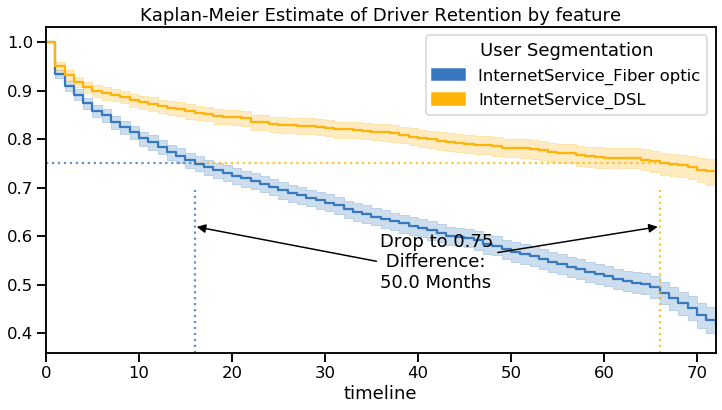

In [703]:
plot_kmf(df, 'InternetService_Fiber optic', 'InternetService_DSL', 'tenure', 'Churn', 0.75)

The graph clearly shows that there is a difference in tenure between "single line" and "multiple line" telco users. Since the confidence interals also appear on the graph, we can see that the difference is statistically significant from t > 0 until approximately t= 52 months, after which the churn rates becomes the same, within the margin of error.

Our survival curves do not follow the constant proportionality assumption (they cannot because they cross, and we can also see varying distances between the curves throughout). Conventionally, ths would mean that a logrank test is not an appropriate measure for estimating the hazard ratio. This presentation by Stone (2015)http://bbs.ceb-institute.org/wp-content/uploads/2016/06/Andy-Stone-Non-Proportional-Hazards-So-What.pdf makes a compelling argument that hazard ratios on nonproportionality are still readily interpretable. This has, however, been a source of controversy in the biostatistics field. Alternative methods such as time-splitting have been proposed, see: Bouliotis & Billingham (2011)https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3287712/



In [704]:
# To get the hazard ratio, we run the logrank test.

multi = (df_copy["MultipleLines_Yes"] == 1)
results = logrank_test(T[multi], T[~multi], C[multi], C[~multi], alpha=0.99 ) #at 99% confidence level
results.print_summary()


In [705]:
# Image Credit: https://en.wikipedia.org/wiki/Log-rank_test
Image(url= "https://wikimedia.org/api/rest_v1/media/math/render/svg/68750c8d50ac1d055b3ddcc67a05de43b40fdebf")

In [706]:
Z = results.test_statistic
D = C.sum() #number of events observed

hazard_ratio = np.exp(Z*np.sqrt(4/D))
print(hazard_ratio)

3.1570355740947154


Therefore the risk of churn is 3.2 times higher in users with only one phoneline compared to users with multiple lines.

# Analyze Churn based on customer life time value

In [707]:
df = df_copy.copy()

In [708]:
pd.qcut(df.TotalCharges, q=2).unique()

[(18.799, 1397.475], (1397.475, 8684.8]]
Categories (2, interval[float64]): [(18.799, 1397.475] < (1397.475, 8684.8]]

In [709]:
df['TotalCharges_bin'] = pd.qcut(df.TotalCharges, q=2, labels=False).astype(str)

In [710]:
df = pd.get_dummies(df)
df.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two

plot features ['TotalCharges_bin_0', 'TotalCharges_bin_1']
vliness [[7.0, 0.7407011938627371], [68.0, 0.7484686034684835]]


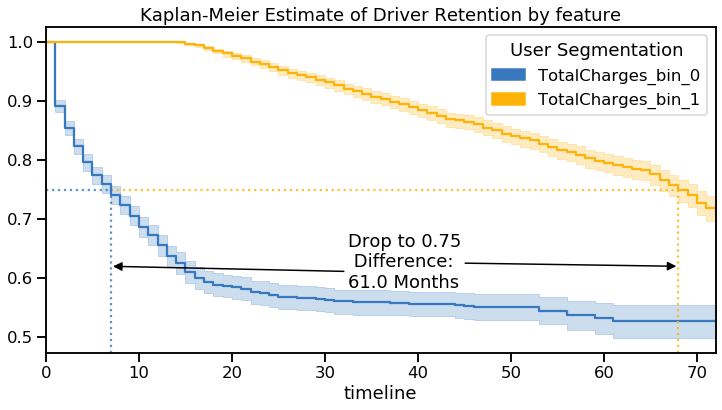

In [711]:
plot_kmf(df, 'TotalCharges_bin_0', 'TotalCharges_bin_1', 'tenure', 'Churn', 0.75)

# References

* https://www.kaggle.com/blastchar/telco-customer-churn
* https://www.kaggle.com/vincentlugat/telco-eda-lightgbm-stylized-report/notebook
* https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
* https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/
* Introduction to Machine Learning with Python by Sarah Guido, Andreas C. Müller, Publisher: O'Reilly Media, Inc., Release Date: October 2016, ISBN: 9781449369880

